In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load your CSV
df = pd.read_csv("/home/elsherif/Desktop/Thesis/ViewPython/data/CleanupDataSet/final_model.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12479 entries, 0 to 12478
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tile                         12479 non-null  object 
 1   total_rooftops               12479 non-null  int64  
 2   rooftops_without_solar       12479 non-null  int64  
 3   square_meters_with_solar_m2  12479 non-null  float64
 4   panel_area_m2                12479 non-null  float64
 5   district_number              12479 non-null  int64  
 6   year                         12479 non-null  int64  
 7   Unemployment_Rate            12479 non-null  float64
 8   Average_Age                  12479 non-null  float64
 9   Elderly_Population           12479 non-null  float64
 10  Young_Population             12479 non-null  float64
 11  Total_Population             12479 non-null  int64  
 12  employed                     12479 non-null  float64
 13  tile_encoded    

In [3]:
df['panel_area_log'] = np.log1p(df['panel_area_m2'])


In [4]:
feature_cols = [
    'total_rooftops',
    # 'rooftops_without_solar',
    # 'square_meters_with_solar_m2',
    'Unemployment_Rate',
    'Average_Age',
    'Elderly_Population',
    'Young_Population',
    'Total_Population',
    'tile_encoded',
    "employed",
    # 'panel_area_lag1',
]

# Drop rows with missing lag values
df_model = df.dropna(subset=feature_cols + ['panel_area_log'])

X = df_model[feature_cols]
y = df_model['panel_area_log']


In [5]:
# Sort by time (CRITICAL)
df_model = df_model.sort_values("year")

# Define years
test_year = df_model["year"].max()
val_year  = df_model[df_model["year"] < test_year]["year"].max()

# Split dataframe
train_df = df_model[df_model["year"] < val_year]
val_df   = df_model[df_model["year"] == val_year]
test_df  = df_model[df_model["year"] == test_year]

# Features and target
X_train = train_df[feature_cols]
y_train = train_df["panel_area_log"]

X_val   = val_df[feature_cols]
y_val   = val_df["panel_area_log"]

X_test  = test_df[feature_cols]
y_test  = test_df["panel_area_log"]

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  r2_score, root_mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import r2_score, root_mean_squared_error

# Predict
y_pred = model.predict(X_test)

# R2 score
print("R2 score:", r2_score(y_test, y_pred))

# RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)



R2 score: 0.6660368671184271
RMSE: 1.319379737770407


In [7]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)          # inverse of log1p
y_test_real = np.expm1(y_test.values)  # convert back to original scale


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "n_estimators": [100, 300, 500,700],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

KeyboardInterrupt: 

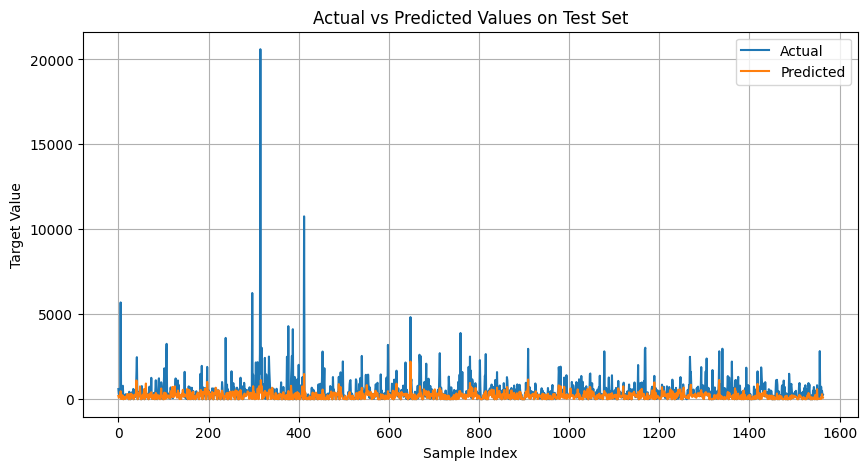

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_real, label="Actual")   # Add markers to see points clearly
plt.plot(y_pred, label="Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.title("Actual vs Predicted Values on Test Set")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import shap
explainer = shap.TreeExplainer(model)
X_shap = X_val.copy()

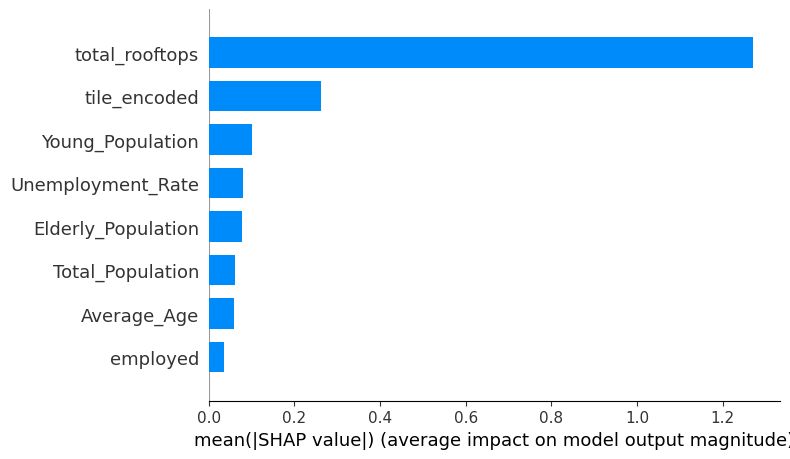

In [10]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Compute SHAP values (if not done yet)
shap_values = explainer.shap_values(X_shap)

# 2️⃣ Optional: sample rows if X_shap is large
if X_shap.shape[0] > 500:  # adjust threshold as needed
    sample_idx = np.random.choice(X_shap.shape[0], 500, replace=False)
    X_plot = X_shap.iloc[sample_idx] if hasattr(X_shap, 'iloc') else X_shap[sample_idx]
    shap_values_plot = shap_values[sample_idx] if isinstance(shap_values, np.ndarray) else [v[sample_idx] for v in shap_values]
else:
    X_plot = X_shap
    shap_values_plot = shap_values

# 3️⃣ Plot summary (faster bar plot)
shap.summary_plot(shap_values_plot, X_plot, plot_type='bar', max_display=15)

